## Change Detection for Remote Sensing Images (Classical Model)

In [1]:
%%capture
!pip install gdown

In [2]:
import gdown
id = '' # insert the id of the file
gdown.download(id=id, output='trainval.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1LB53KldZ_hG_Kc2wEBmRjLH0Js80WGgr
From (redirected): https://drive.google.com/uc?id=1LB53KldZ_hG_Kc2wEBmRjLH0Js80WGgr&confirm=t&uuid=e8690020-62f9-4976-bf6d-6aa49e4b2974
To: /kaggle/working/trainval.zip
100%|██████████| 756M/756M [00:28<00:00, 26.5MB/s] 


'trainval.zip'

In [3]:
%%capture
!unzip trainval.zip

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [5]:
# Function to load images from directory
def load_images_from_folder(folder, is_gray = True):
    images = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename)).astype(np.uint8)
        if img is not None:
            img = img/255
            if is_gray:
                images.append(color.rgb2gray(img))
            else:    
                images.append(img)
    return images


In [6]:
# Load images from folders A and B
folder_A = 'trainval/A'
folder_B = 'trainval/B'
folder_label = 'trainval/label'

In [7]:
images_A = load_images_from_folder(folder_A)

In [8]:
images_A = np.array(images_A)

In [9]:
print(images_A[40].shape)

(256, 256)


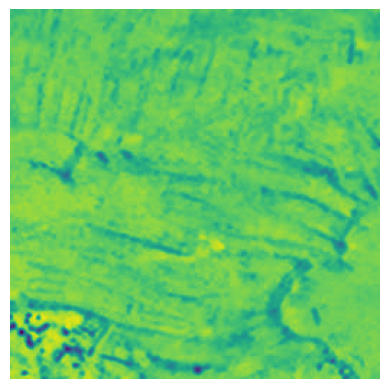

In [10]:
plt.imshow(images_A[40])
plt.axis('off')  
plt.show()

In [11]:
images_B = load_images_from_folder(folder_B)


In [12]:
images_B = np.array(images_B)

In [13]:
labels = load_images_from_folder(folder_label, is_gray = False)

In [14]:
labels = np.array(labels)

In [17]:
def calculate_jaccard_index(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    jaccard_index = intersection / union
    return jaccard_index

###################################################################

def calculate_jaccard_index_avg(pred_mask, true_mask):
    arr = []
    for i in range(len(pred_mask)):
        intersection = np.logical_and(pred_mask[i], true_mask[i]).sum()
        union = np.logical_or(pred_mask[i], true_mask[i]).sum()
        if union != 0:
            arr.append(intersection / union)
        else:
            arr.append(1)
    
    jaccard_index = np.array(arr).mean()        
    return jaccard_index

In [18]:
def change_detection_cva(images_time1, images_time2):
    if images_time1.shape != images_time2.shape:
        raise ValueError("Input arrays must have the same shape")

    change_images = np.zeros_like(images_time1, dtype=np.uint8)

    change_vectors = np.abs(images_time2 - images_time1)


    for i in range(images_time1.shape[0]):
        for j in range(images_time1.shape[1]):
            magnitude = np.linalg.norm(change_vectors[i, j])
            change_images[i, j] = magnitude
            
           

    return change_images

In [17]:
cva_mask = change_detection_cva(images_A, images_B)

In [ ]:
print(cva_mask)

In [19]:
cva_mask_thresholded = cva_mask > 2

In [20]:
jaccard_index = calculate_jaccard_index(cva_mask_thresholded, labels)
jaccard_index_avg = calculate_jaccard_index_avg(cva_mask_thresholded, labels)
print("For CVA Jaccard Index:", jaccard_index)
print("For CVA Jaccard Index Avg:", jaccard_index_avg)

For CVA Jaccard Index: 0.18301865313962745
For CVA Jaccard Index Avg: 0.5690975386955706


In [21]:
def image_difference(image_A, image_B):
    diff = np.abs(image_A - image_B)
    return diff

In [22]:
change_mask = image_difference(images_A, images_B)

In [ ]:
thresholds = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]

for th in thresholds:
    change_mask_thresholded = change_mask > th
    jaccard_index = calculate_jaccard_index(change_mask_thresholded, labels)
    jaccard_index_avg = calculate_jaccard_index_avg(change_mask_thresholded, labels)
    print(f"Threshold:{th} | Avg jaccard:{jaccard_index_avg}")
    change_flattened = change_mask_thresholded.flatten()
    label_flattened = (labels).astype(np.bool_).flatten()
    print(f"Precision: {precision_score(label_flattened,  change_flattened, zero_division=1)}")
    print(f"Recall: {recall_score(label_flattened, change_flattened, zero_division= 1)}")
    print(f"F1 Score: {f1_score(label_flattened, change_flattened , zero_division= 1)}")
    print(confusion_matrix(label_flattened, change_flattened))
    print("===========================================================================================================")

Threshold:0.05 | Avg jaccard:0.06715897795110277
Precision: 0.09802795667023155
Recall: 0.8247123269256007
F1 Score: 0.17522777684360713
[[130947746 166181816]
 [  3838745  18060941]]
Threshold:0.1 | Avg jaccard:0.0632290815218716
Precision: 0.1284783088048737
Recall: 0.6627006889505174
F1 Score: 0.21522983800566126
[[198682287  98447275]
 [  7386749  14512937]]
Threshold:0.15 | Avg jaccard:0.057285545712521924
Precision: 0.15130495881446038
Recall: 0.5282662043647567
F1 Score: 0.23523451442686308
[[232237852  64891710]
 [ 10330822  11568864]]
Threshold:0.2 | Avg jaccard:0.05627842701603991
Precision: 0.1683718786960321
Recall: 0.42468987911516176
F1 Score: 0.24114127025730442
[[251191845  45937717]
 [ 12599111   9300575]]
Threshold:0.25 | Avg jaccard:0.07942180485634148
Precision: 0.18383399097020053
Recall: 0.3330731773962421
F1 Score: 0.23690974021265598
[[264745581  32383981]
 [ 14605488   7294198]]
Threshold:0.3 | Avg jaccard:0.12453583859124055
Precision: 0.19249614521637937
Reca

In [19]:
def image_ratioing(images_A, images_B):
    epsilon = 1e-8
    ratio = (images_A + epsilon) / (images_B + epsilon)
    
    return ratio

In [20]:
change_mask = image_ratioing(images_A, images_B)

In [ ]:
thresholds = [0.05 , 0.1, 0.15 , 0.2 , 0.25, 0.3 , 0.35 , 0.4, 0.45, 0.5]

for th in thresholds:
    ratio_thresholded = np.logical_or(change_mask > 1 + th, change_mask < 1 - th)
    jaccard_index_avg = calculate_jaccard_index_avg(ratio_thresholded, labels)
    print(f"Threshold:{th} | Avg jaccard:{jaccard_index_avg}")
    change_flattened = ratio_thresholded.flatten()
    label_flattened = (labels).astype(np.bool_).flatten()
    print(f"Precision: {precision_score(label_flattened,  change_flattened, zero_division=1)}")
    print(f"Recall: {recall_score(label_flattened, change_flattened, zero_division= 1)}")
    print(f"F1 Score: {f1_score(label_flattened, change_flattened , zero_division= 1)}")
    print(confusion_matrix(label_flattened, change_flattened))
    print("===========================================================================================================")

Threshold:0.05 | Avg jaccard:0.0674411567358934
Precision: 0.09047602024235593
Recall: 0.8695192707329228
F1 Score: 0.1638979771661742
[[105704955 191424607]
 [  2857487  19042199]]
Threshold:0.1 | Avg jaccard:0.06448193079703876
Precision: 0.11434624774122842
Recall: 0.7421404124241782
F1 Score: 0.19816063788184154
[[171246871 125882691]
 [  5647044  16252642]]
Threshold:0.15 | Avg jaccard:0.059457828125849724
Precision: 0.13131345487780816
Recall: 0.6287602023152296
F1 Score: 0.21725440337083876
[[206038283  91091279]
 [  8130035  13769651]]
Threshold:0.2 | Avg jaccard:0.05443995558680849
Precision: 0.14177972292601754
Recall: 0.5373309462062607
F1 Score: 0.2243599935487378
[[225899325  71230237]
 [ 10132307  11767379]]
Threshold:0.25 | Avg jaccard:0.05245388664070294
Precision: 0.14756711451725646
Recall: 0.4593978653392565
F1 Score: 0.22338032556516632
[[239013327  58116235]
 [ 11839017  10060669]]
Threshold:0.3 | Avg jaccard:0.054793354029051076
Precision: 0.1500388661782259
Recal